data.shape = (1500, 1500)
data.dtype=float32
Duration cpu = 4.279931545257568 s


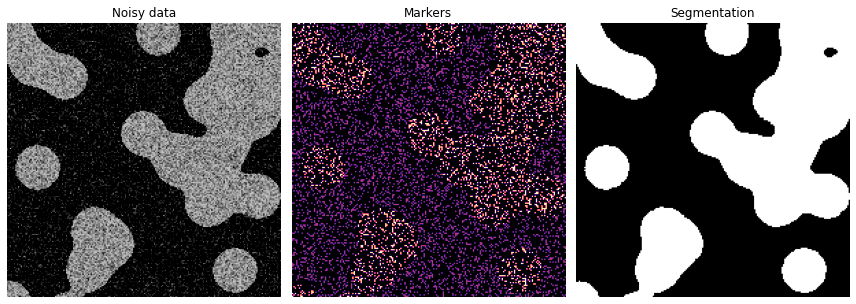

data.shape = (1500, 1500)
data.dtype=float32
Duration gpu = 0.2667715549468994 s


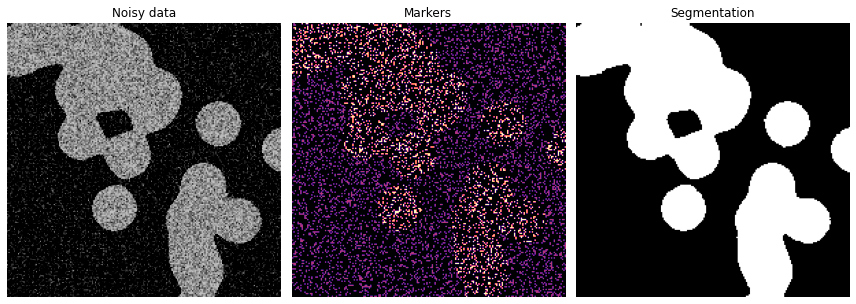

GPU Acceleration = 16.0434


In [25]:
import time

import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

durations = {}
for use_gpu in (False, True):
    length = 1500
    blob_size_fraction = 0.025
    if use_gpu:
        from cucim import skimage
        from cucim.skimage.exposure import rescale_intensity
        from cucim.skimage.segmentation import random_walker

        try:
            from cucim.skimage.data import binary_blobs

            blobs = binary_blobs(
                length=length, seed=1, blob_size_fraction=blob_size_fraction
            )
        except ImportError:
            from skimage.data import binary_blobs

            blobs = cp.asarray(
                binary_blobs(
                    length=length, seed=1, blob_size_fraction=blob_size_fraction
                )
            )
        asnumpy = cp.asnumpy
        xp = cp
        device_name = "gpu"
    else:
        import skimage
        from skimage.data import binary_blobs
        from skimage.exposure import rescale_intensity
        from skimage.segmentation import random_walker

        blobs = binary_blobs(
            length=length, seed=1, blob_size_fraction=blob_size_fraction
        )
        asnumpy = np.asarray
        xp = np
        device_name = "cpu"

    # Generate noisy synthetic data
    data = skimage.img_as_float(blobs)
    print(f"data.shape = {data.shape}")
    sigma = 0.3
    data += xp.random.normal(loc=0, scale=sigma, size=data.shape)
    data = rescale_intensity(data, in_range=(-sigma, 1 + sigma), out_range=(-1, 1))
    data = data.astype(np.float32, copy=False)

    print(f"data.dtype={data.dtype}")
    # The range of the binary image spans over (-1, 1).
    # We choose the hottest and the coldest pixels as markers.
    markers = xp.zeros(data.shape, dtype=np.uint)
    markers[data < -0.95] = 1
    markers[data > 0.95] = 2

    tstart = time.time()
    # Run random walker algorithm
    labels = random_walker(data, markers, beta=5, mode="cg", tol=1e-5)

    dur = time.time() - tstart
    durations[device_name] = dur
    print(f"Duration {device_name} = {dur} s")

    # Plot results
    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3, figsize=(12, 4.8), sharex=True, sharey=True
    )
    ax1.imshow(asnumpy(data[:200, :200]), vmin=-0.5, vmax=1.5, cmap="gray")
    ax1.axis("off")
    ax1.set_title("Noisy data")
    ax2.imshow(asnumpy(markers[:200, :200]), cmap="magma")
    ax2.axis("off")
    ax2.set_title("Markers")
    ax3.imshow(asnumpy(labels[:200, :200]), cmap="gray")
    ax3.axis("off")
    ax3.set_title("Segmentation")

    fig.tight_layout()
    plt.show()

print(f"GPU Acceleration = {durations['cpu'] / durations['gpu']:0.4f}")